## Run Clay v1

This notebook shows how to run Clay v1 wall-to-wall, from downloading imagery
to training a tiny fine tuning head. This will include the following steps:

1. Set a location and date range of interest
2. Download Sentinel-2 imagery for this specification
3. Load the model checkpoint
4. Prepare data into a format for the model
5. Run the model on the imagery
6. Analyise the model embeddings output using PCA
7. Train a Support Vector Machines fine tuning head

In [2]:
# Add the repo root to the sys path for the model import below
import sys

sys.path.append("..")

In [3]:
import math

import geopandas as gpd
import numpy as np
import pandas as pd
import pystac_client
import stackstac
import torch
import yaml
from box import Box
from matplotlib import pyplot as plt
from rasterio.enums import Resampling
from shapely import Point

#from skimage.restoration import inpaint_biharmonic
from sklearn import decomposition, svm
from stacchip.processors.prechip import normalize_timestamp
from torchvision.transforms import v2


### Specify location and date of interest
In this example we will use a location in Portugal where a forest fire happened. We will run the model over the time period of the fire and analyse the model embeddings.

In [4]:
# Point over Monchique Portugal
lat, lon = 37.30939, -8.57207

# Dates of a large forest fire
start = "2018-07-01"
end = "2018-09-01"

### Get data from STAC catalog

Based on the location and date we can obtain a stack of imagery using stackstac. Let's start with finding the STAC items we want to analyse.

In [5]:
import planetary_computer

STAC_API = "https://earth-search.aws.element84.com/v1"
STAC_API = "https://planetarycomputer.microsoft.com/api/stac/v1/"
COLLECTION = "sentinel-2-l2a"
COLLECTION = "landsat-c2-l2"

# Search the catalogue
catalog = pystac_client.Client.open(STAC_API, modifier=planetary_computer.sign_inplace)
search = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start}/{end}",
    bbox=(lon - 1e-5, lat - 1e-5, lon + 1e-5, lat + 1e-5),
    max_items=100,
    query={"eo:cloud_cover": {"lt": 80}, "platform": {"eq": "landsat-7"}},
)

all_items = search.get_all_items()

# Reduce to one per date (there might be some duplicates
# based on the location)
items = []
dates = []
for item in all_items:
    if item.datetime.date() not in dates:
        items.append(item)
        dates.append(item.datetime.date())

print(f"Found {len(items)} items")

/Users/fgassert/Documents/git/ecosystem-condition-pilot/.venv/lib/python3.12/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


Found 7 items


In [6]:
items[0]

<Item id=LE07_L2SP_204034_20180829_02_T1>

### Create a bounding box around the point of interest

This is needed in the projection of the data so that we can generate image chips of the right size.

In [7]:
# Extract coordinate system from first item
epsg = items[0].properties["proj:epsg"]

# Convert point of interest into the image projection
# (assumes all images are in the same projection)
poidf = gpd.GeoDataFrame(
    pd.DataFrame(),
    crs="EPSG:4326",
    geometry=[Point(lon, lat)],
).to_crs(epsg)

coords = poidf.iloc[0].geometry.coords[0]

# Create bounds in projection
size = 256
gsd = 30
bounds = (
    coords[0] - (size * gsd) // 2,
    coords[1] - (size * gsd) // 2,
    coords[0] + (size * gsd) // 2,
    coords[1] + (size * gsd) // 2,
)

### Retrieve the imagery data.

In [8]:
# Retrieve the pixel values, for the bounding box in
# the target projection. In this example we use only
# the RGB and NIR bands.
img_stack = stackstac.stack(
    items,
    bounds=bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=gsd,
    rescale=False,
    dtype="float32",
    fill_value=0,
    assets=["blue", "green", "red", "nir08", "swir22"],
    resampling=Resampling.nearest,
)

print(f"Working with stack of size {img_stack.shape}")

img_stack = img_stack.compute()


Working with stack of size (7, 5, 256, 256)


In [15]:
import rioxarray

img_stack.rio.transform()

<xarray.DataArray 'x' ()> Size: 8B
array(534080.79691545)
Coordinates: (12/13)
    proj:epsg                    int64 8B 32629
    landsat:collection_number    <U2 8B '02'
    gsd                          int64 8B 30
    sci:doi                      <U16 64B '10.5066/P9C7I13B'
    view:off_nadir               int64 8B 0
    landsat:collection_category  <U2 8B 'T1'
    ...                           ...
    landsat:correction           <U4 16B 'L2SP'
    landsat:wrs_row              <U3 12B '034'
    landsat:wrs_type             <U1 4B '2'
    platform                     <U9 36B 'landsat-7'
    raster:bands                 object 8B {'scale': 2.75e-05, 'nodata': 0, '...
    epsg                         int64 8B 32629


Affine(30.0, 0.0, 534065.79691545,
       0.0, -30.0, 4133135.740728332)

In [8]:
import xarray as xr

qa_stack = stackstac.stack(
    items,
    bounds=bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=gsd,
    rescale=False,
    dtype="uint16",
    fill_value=1,
    assets=["qa_pixel"],
    resampling=Resampling.nearest,
)
qa_stack = qa_stack.compute()

# bits 1, 3, and 4 are dilated cloud, cloud, and cloud shadow
# 0b10000 cloud shadow
# 0b01000 cloud
# 0b00010 dilated cloud
cloud = (qa_stack & 0b10001) > 0
cloud_shadow = (qa_stack & 0b01000) > 0
dilated_cloud = (qa_stack & 0b00010) > 0

cloud_mask = xr.concat([cloud,cloud_shadow,dilated_cloud], dim='band')
cloud_mask.coords['band'] = ['cloud','cloud_shadow','dilated_cloud']

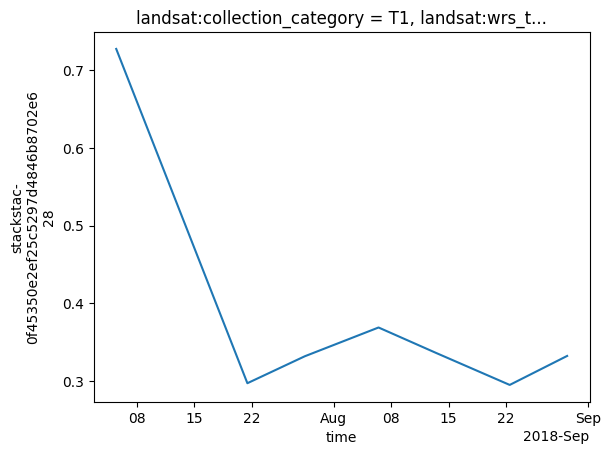

In [9]:
import cv2
def inpaint_l7(arr):
    data = arr.data.reshape(arr.shape[-1], arr.shape[-2])
    mask = (data==0).astype(np.uint8)
    data = cv2.inpaint(data, mask, 3, cv2.INPAINT_TELEA)
    arr.data = data.reshape(arr.shape)
    return arr

chunked = img_stack.chunk({"time": 1, "band": 1})
filled = chunked.map_blocks(inpaint_l7, template=chunked)
filled.compute()
filled

chunked = (cloud_mask*254+1-np.expand_dims((img_stack[:,0]==0),1)).astype('uint8').chunk({"time":1, "band":1})
cloud_filled = (chunked.map_blocks(inpaint_l7, template=chunked).compute())>127

cloud_filled.sum("band").mean(["x", "y"]).plot()

In [10]:
for time_index in img_stack.time:
    # Select the data for the current time index
    time_data = img_stack.sel(time=time_index)
    
    # Perform operations on the time data
    # ...
    
    # Print the time index and data
    print(f"Time index: {time_index.values}")
    print(time_data)

Time index: 2018-07-05T11:08:02.688433000
<xarray.DataArray 'stackstac-8c70d7770d98737fadbc5c3dc5f91522' (band: 5,
                                                                y: 256, x: 256)> Size: 1MB
array([[[    0.,     0.,     0., ..., 23494., 21588., 18455.],
        [    0.,     0.,     0., ..., 22003., 19309., 15855.],
        [    0.,     0.,     0., ..., 21669., 20072., 16379.],
        ...,
        [ 9311.,  9488.,  9665., ...,  8702.,  8612.,  8703.],
        [ 9221.,  9309.,  9220., ...,  8611.,  8612.,  8792.],
        [ 9042.,  9219.,  9219., ...,  8611.,  8519.,  8339.]],

       [[    0.,     0.,     0., ..., 24737., 22744., 19568.],
        [    0.,     0.,     0., ..., 23409., 20438., 16734.],
        [    0.,     0.,     0., ..., 22933., 21114., 17421.],
        ...,
        [10391., 10489., 10784., ...,  9359.,  9259.,  9459.],
        [ 9800., 10096., 10293., ...,  9258.,  9359.,  9658.],
        [ 9800.,  9899.,  9799., ...,  9458.,  9159.,  9059.]],

       [

In [11]:
cloud_mask.sum("band")

<xarray.DataArray 'stackstac-0f45350e2ef25c5297d4846b8702e628' (time: 7,
                                                                y: 256, x: 256)> Size: 4MB
array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
...
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 1, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates: (12/26)
  * time                         (time) datetime64[ns] 56B 2018-07-05T11:08:0...
    id                           (time) <U31 868B 'LE07_L2SP_203034_20180705_...
  * x                            (x) float64 2kB 5.341e+05 ... 5.417e+05
  * y                            (y) float64 2kB 4.133e+06 ... 4.125e+06
    landsat:collection_category  <U2 8B 'T1'
    landsat:wrs_type             <U1 4B '2'
    ...                           ...
    view:sun_azimuth             (time) float64 56B 121.8 124.9 ... 137.2 140.3
    instruments                  <U4 16B 'etm+'
    eo:cloud_cover               (time) float64 56B 13.0 0.0 2.0 ... 6.0 4.0
    raster:bands                 object 8B {'unit': 'bit index', 'nodata': 1,...
    title                        <U29 116B 'Pixel Quality Assessment Band'
    epsg                         int64 8B 32629

In [12]:
#mask = (cloud_mask.sum("band") + (img_stack.data[:,0]==0)) > 0
#filled = img_stack.copy() 
#filled.data = inpaint_biharmonic(img_stack.data, mask=mask.data, channel_axis=1)

### Let's have a look at the imagery we just downloaded

The imagery will contain 7 dates before the fire, of which two are pretty cloudy images. There are also 5 images after the forest fire.

In [1]:
img_stack.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=5000, vmax=25000, col_wrap=6
)
img_stack.sel(band=["swir22", "nir08", "green"]).plot.imshow(
    row="time", rgb="band", vmin=5000, vmax=25000, col_wrap=6
)
cloud_mask.plot.imshow(row="time", rgb="band", col_wrap=6, vmin=0, vmax=1)

filled.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=5000, vmax=25000, col_wrap=6
)
#mask.plot.imshow(row="time", col_wrap=6, vmin=0, vmax=1)

NameError: name 'img_stack' is not defined

![Minicube visualization](https://github.com/Clay-foundation/model/assets/901647/c6e924e5-6ba1-4924-b99a-df8b90731a5f)

In [ ]:
stack = filled
if len(stack['time']) < 32:
    stack = stack.reindex(time=np.concatenate([
        stack['time'],
        np.arange(32-len(stack['time'])).astype(stack['time'].dtype)
    ]), method='pad')

stack

<xarray.DataArray 'stackstac-61bddd2345b1a6555a957867d0885e75' (time: 32,
                                                                band: 4,
                                                                y: 256, x: 256)> Size: 34MB
dask.array<where, shape=(32, 4, 256, 256), dtype=float32, chunksize=(18, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * time                         (time) datetime64[ns] 256B 2018-07-04T11:14:...
  * band                         (band) <U5 80B 'blue' 'green' 'red' 'nir08'
  * x                            (x) float64 2kB 5.341e+05 ... 5.417e+05
  * y                            (y) float64 2kB 4.133e+06 ... 4.125e+06
    id                           (time) object 256B dask.array<chunksize=(1,), meta=np.ndarray>
    view:sun_elevation           (time) float64 256B dask.array<chunksize=(1,), meta=np.ndarray>
    ...                           ...
    created                      (time) object 256B dask.array<chunksize=(1,), meta=np.ndarray>
    description                  <U28 112B dask.array<chunksize=(), meta=np.ndarray>
    landsat:scene_id             (time) object 256B dask.array<chunksize=(1,), meta=np.ndarray>
    title                        (band) <U22 352B dask.array<chunksize=(1,), meta=np.ndarray>
    raster:bands                 object 8B dask.array<chunksize=(), meta=np.ndarray>
    epsg                         int64 8B dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32629, bounds=(534080.79691545, 4125440.7407...
    crs:         epsg:32629
    transform:   | 30.00, 0.00, 534080.80|\n| 0.00,-30.00, 4133120.74|\n| 0.0...
    resolution:  30

### Load the model

We now have the data to analyse, let's load the model.

### Prepare band metadata for passing it to the model

This is the most technical part so far. We will take the information in the stack of imagery and convert it into the formate that the model requires. This includes converting the lat/lon and the date of the imagery into normalized values.

The Clay model will accept any band combination in any order, from different platforms. But for this the model needs to know the wavelength of each band that is passed to it, and normalization parameters for each band as well. It will use that to normalize the data and to interpret each band based on its central wavelength.

For Sentinel-2 we can use medata file of the model to extract those values. But this cloud also be something custom for a different platform.

In [16]:
# Extract mean, std, and wavelengths from metadata
#platform = "sentinel-2-l2a"
platform = "landsat-c2l2-sr"
metadata = Box(yaml.safe_load(open("../conf/clay/metadata.yaml")))
mean = []
std = []
waves = []
# Use the band names to get the correct values in the correct order.
for band in img_stack.band:
    mean.append(metadata[platform].bands.mean[str(band.values)])
    std.append(metadata[platform].bands.std[str(band.values)])
    waves.append(metadata[platform].bands.wavelength[str(band.values)])

# Prepare the normalization transform function using the mean and std values.
transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)

### Convert the band pixel data in to the format for the model

We will take the information in the stack of imagery and convert it into the formate that the model requires. This includes converting the lat/lon and the date of the imagery into normalized values.

In [18]:
# Prep datetimes embedding using a normalization function from the model code.
datetimes = img_stack.time.values.astype("datetime64[s]").tolist()
times = [normalize_timestamp(dat) for dat in datetimes]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]


# Prep lat/lon embedding using the
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))


latlons = [normalize_latlon(lat, lon)] * len(times)
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

# Normalize pixels
#pixels = torch.from_numpy(stack.data.astype(np.float32))
pixels = torch.from_numpy(filled.to_numpy().astype(np.float32))
pixels = transform(pixels)

### Combine the metadata and the transformed pixels

Now we can combine all of these inputs into a dictionary that combines everything.

In [24]:
# Prepare additional information
device = "mps"  # Replace with "cuda" if you have a GPU
datacube = {
    "platform": platform,
    "time": torch.tensor(
        np.hstack((week_norm, hour_norm)),
        dtype=torch.float32,
        device=device,
    ),
    "latlon": torch.tensor(
        np.hstack((lat_norm, lon_norm)), dtype=torch.float32, device=device
    ),
    #"pixels": pixels.to(device),
    "gsd": torch.tensor(img_stack.gsd.values.reshape(1), device=device),
    "waves": torch.tensor(waves, device=device),
}
datacube

{'platform': 'landsat-c2l2-sr',
 'time': tensor([[-0.1205, -0.9927,  0.2588, -0.9659],
         [-0.3546, -0.9350,  0.2588, -0.9659],
         [-0.4647, -0.8855,  0.2588, -0.9659],
         [-0.6631, -0.7485,  0.2588, -0.9659],
         [-0.7485, -0.6631,  0.2588, -0.9659],
         [-0.8230, -0.5681,  0.2588, -0.9659],
         [-0.8855, -0.4647,  0.2588, -0.9659]], device='mps:0'),
 'latlon': tensor([[ 0.6061,  0.7954, -0.1491,  0.9888],
         [ 0.6061,  0.7954, -0.1491,  0.9888],
         [ 0.6061,  0.7954, -0.1491,  0.9888],
         [ 0.6061,  0.7954, -0.1491,  0.9888],
         [ 0.6061,  0.7954, -0.1491,  0.9888],
         [ 0.6061,  0.7954, -0.1491,  0.9888],
         [ 0.6061,  0.7954, -0.1491,  0.9888]], device='mps:0'),
 'gsd': tensor([30], device='mps:0'),
 'waves': tensor([0.4800, 0.5600, 0.6500, 0.8600, 2.2000], device='mps:0')}

### Run the model

Pass the datacube we prepared to the model to create embeddings. This will create one embedding vector for each of the images we downloaded.

In [28]:
encoder = torch.export.load("../data/06_models/clay_encoder_mps.pt").module()

with torch.inference_mode():
    results = encoder(
        pixels.to(device), 
        datacube["time"], 
        datacube["latlon"], 
        datacube["waves"],
        datacube["gsd"], 
    )



In [29]:
embeddings = results[0][:, 0, :].cpu().numpy()
embeddings.shape

(7, 768)

### Analyse the embeddings

A simple analysis of the embeddings is to reduce each one of them into a single number using Principal Component Analysis. For this we will fit a PCA on the 12 embeddings we have, and do the dimensionality reduction for them. We will se a separation into three groups, the previous images, the cloudy images, and the images after the fire, they all fall into a different range of the PCA space.

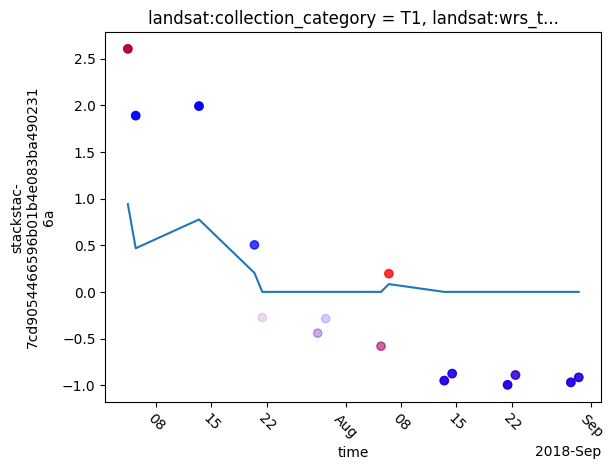

In [195]:
# Run PCA
import numpy as np

nimgs = 15
s = stack[:nimgs]

pca = decomposition.PCA(n_components=3)
pca_result = pca.fit_transform(embeddings[:nimgs])

def normalize(array):
    return (array - min(array)) / (max(array) - min(array))
 
plt.xticks(rotation=-45)

# Plot all points in blue first
plt.scatter(s.time, y=pca_result[:, 0], alpha=normalize(pca_result[:,1]), c='r')
plt.scatter(s.time, y=pca_result[:, 0], alpha=normalize(pca_result[:,2]), c='b')

cloud_filled.sum("band").mean(["x", "y"]).plot()


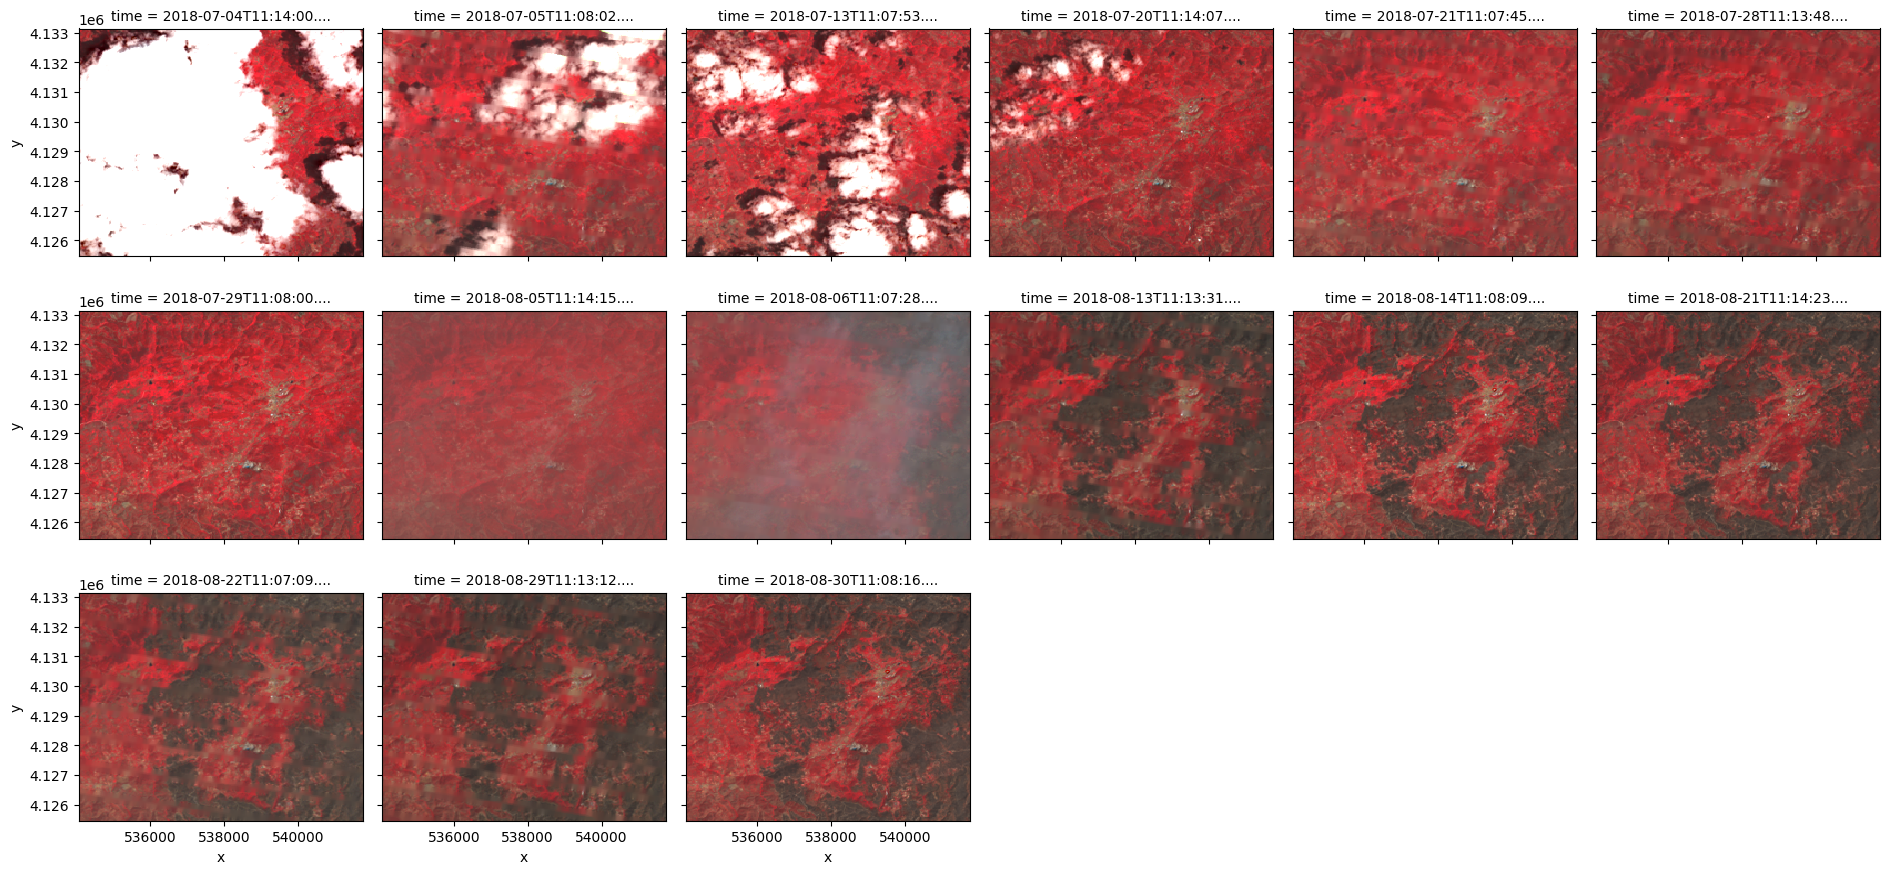

In [200]:
filled.sel(band=["nir08", "red", "green"]).plot.imshow(
    row="time", rgb="band", vmin=5000, vmax=25000, col_wrap=6
)

### And finally, some finetuning

We are going to train a classifier head on the embeddings and use it to detect fires.

In [ ]:
# Label the images we downloaded
# 0 = Cloud
# 1 = Forest
# 2 = Fire
labels = np.array([0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2])

# Split into fit and test manually, ensuring we have all 3 classes in both sets
fit = [0, 1, 3, 4, 7, 8, 9]
test = [2, 5, 6, 10, 11]

# Train a support vector machine model
clf = svm.SVC()
clf.fit(embeddings[fit] + 100, labels[fit])

# Predict classes on test set
prediction = clf.predict(embeddings[test] + 100)

# Perfect match for SVM
match = np.sum(labels[test] == prediction)
print(f"Matched {match} out of {len(test)} correctly")

Matched 5 out of 5 correctly
